In [1]:
import keras, os
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, losses
from keras.layers import Input, Dense, Conv2D, MaxPool2D , Flatten, MaxPooling2D, GlobalAveragePooling2D ,AveragePooling2D, Dropout, Activation, BatchNormalization,ZeroPadding2D,Add
from keras.layers import Activation, Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras_preprocessing.image import ImageDataGenerator

train_DataGenerator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

TRAIN_AUG_DIR = r"/content/drive/MyDrive/New_Train"

labels=['Basketball','Football','Rowing','Swimming','Tennis','Yoga']

train_d = train_DataGenerator.flow_from_directory(
      TRAIN_AUG_DIR,
      classes=labels,
      color_mode="rgb",
      batch_size=16,
      target_size=(64,64),
      class_mode="categorical",
      subset="training")

valid_d = train_DataGenerator.flow_from_directory(
    TRAIN_AUG_DIR,
    classes=labels,
    color_mode="rgb",
    batch_size=16,
    target_size=(64,64),
    class_mode="categorical",
    subset="validation")

Found 7073 images belonging to 6 classes.
Found 1764 images belonging to 6 classes.


In [12]:
def history_plot(history):
  fig=plt.figure(figsize=(15 , 7))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("model accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
  plt.show()


In [5]:
def Convolutional_w_Batch_Normalisation(prev_layer , num_kernels , filter_Size , strides =(1,1) , padding = 'same', kernel_regularizer = regularizers.L2(0.001)):
    x = Conv2D(filters=num_kernels, kernel_size = filter_Size, strides=strides , padding=padding, kernel_regularizer = kernel_regularizer)(prev_layer)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    return x

def Convolutional_without_Activation(prev_layer , num_kernels , filter_Size , strides =(1,1) , padding = 'same', kernel_regularizer = regularizers.L2(0.001)):
    x = Conv2D(filters=num_kernels, kernel_size = filter_Size, strides=strides , padding=padding, kernel_regularizer = kernel_regularizer)(prev_layer)
    x = BatchNormalization(axis=3)(x)
    return x

In [6]:
def identityBlock(x, kernels): 
  x_skip = x 
  k1, k2 = kernels

  #first block 
  x = Convolutional_w_Batch_Normalisation(x ,num_kernels = k1 , filter_Size=(1, 1) , strides =(1,1) , padding = 'valid', kernel_regularizer=regularizers.L2(0.001))

  #second block (bottleneck)
  x = Convolutional_w_Batch_Normalisation(x ,num_kernels = k1 , filter_Size=(3, 3) , strides =(1,1) , padding = 'same', kernel_regularizer=regularizers.L2(0.001))

  # third block
  x = Convolutional_without_Activation(x , num_kernels = k2 , filter_Size =(1, 1) , strides =(1,1) , padding = 'valid', kernel_regularizer = regularizers.L2(0.001))

  # add the input 
  x = Add()([x, x_skip])
  x = Activation('relu')(x)
  return x

In [7]:
def convBlock(x, s, kernels):
  x_skip = x
  k1, k2 = kernels

  # first block
  x = Convolutional_w_Batch_Normalisation(x ,num_kernels = k1 , filter_Size=(1, 1) , strides = (s, s) , padding = 'valid', kernel_regularizer=regularizers.L2(0.001))

  # second block
  x = Convolutional_w_Batch_Normalisation(x ,num_kernels = k1 , filter_Size=(3, 3) , strides = (1, 1) , padding = 'same', kernel_regularizer=regularizers.L2(0.001))

  #third block
  x = Convolutional_without_Activation(x ,num_kernels = k2 , filter_Size=(1, 1) , strides = (1, 1) , padding = 'valid', kernel_regularizer=regularizers.L2(0.001))

  # shortcut 
  x_skip = Convolutional_without_Activation(x_skip ,num_kernels = k2 , filter_Size=(1, 1) , strides = (s, s) , padding = 'valid', kernel_regularizer=regularizers.L2(0.001))

  # add 
  x = Add()([x, x_skip])
  x = Activation("relu")(x)

  return x

In [8]:
def resnet50(in_shape = (64, 64, 3), classes = 6):

  input_im = Input(shape=in_shape)

  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  x = convBlock(x, s=1, kernels=(64, 256))
  x = identityBlock(x, kernels=(64, 256))
  x = identityBlock(x, kernels=(64, 256))

  # 3rd stage
  x = convBlock(x, s=2, kernels=(128, 512))
  x = identityBlock(x, kernels=(128, 512))
  x = identityBlock(x, kernels=(128, 512))
  x = identityBlock(x, kernels=(128, 512))

  # 4th stage
  x = convBlock(x, s=2, kernels=(256, 1024))
  x = identityBlock(x, kernels=(256, 1024))
  x = identityBlock(x, kernels=(256, 1024))
  x = identityBlock(x, kernels=(256, 1024))
  x = identityBlock(x, kernels=(256, 1024))
  x = identityBlock(x, kernels=(256, 1024))

  # 5th stage
  x = convBlock(x, s=2, kernels=(512, 2048))
  x = identityBlock(x, kernels=(512, 2048))
  x = identityBlock(x, kernels=(512, 2048))

  # ends with average pooling and dense connection
  x = AveragePooling2D((2, 2), padding='same')(x)  #we need try global also

  x = Flatten()(x)
  x = Dense(classes, activation='softmax')(x)

  # define the model 
  model = Model(inputs=input_im, outputs=x)
  return model

In [9]:
model_resnet = resnet50()
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(restore_best_weights=True,patience=3)

In [11]:
history = model_resnet.fit(train_d,validation_data=valid_d,epochs=30,callbacks = [early_stopping])

Epoch 1/30
443/443 [==============================] - 3257s 7s/step - loss: 16.2898 - acc: 0.4728 - val_loss: 12.9152 - val_acc: 0.3866
Epoch 2/30
443/443 [==============================] - 51s 115ms/step - loss: 8.8666 - acc: 0.5742 - val_loss: 9.8792 - val_acc: 0.1865
Epoch 3/30
443/443 [==============================] - 51s 115ms/step - loss: 5.7691 - acc: 0.5958 - val_loss: 6.3918 - val_acc: 0.3588
Epoch 4/30
443/443 [==============================] - 50s 114ms/step - loss: 4.3688 - acc: 0.6176 - val_loss: 4052.3110 - val_acc: 0.1831
Epoch 5/30
443/443 [==============================] - 54s 121ms/step - loss: 3.5150 - acc: 0.6402 - val_loss: 3.0857 - val_acc: 0.5975
Epoch 6/30
443/443 [==============================] - 50s 113ms/step - loss: 3.0249 - acc: 0.6569 - val_loss: 3.0354 - val_acc: 0.6049
Epoch 7/30
443/443 [==============================] - 50s 113ms/step - loss: 2.9500 - acc: 0.6178 - val_loss: 4.3930 - val_acc: 0.3056
Epoch 8/30
443/443 [==============================]

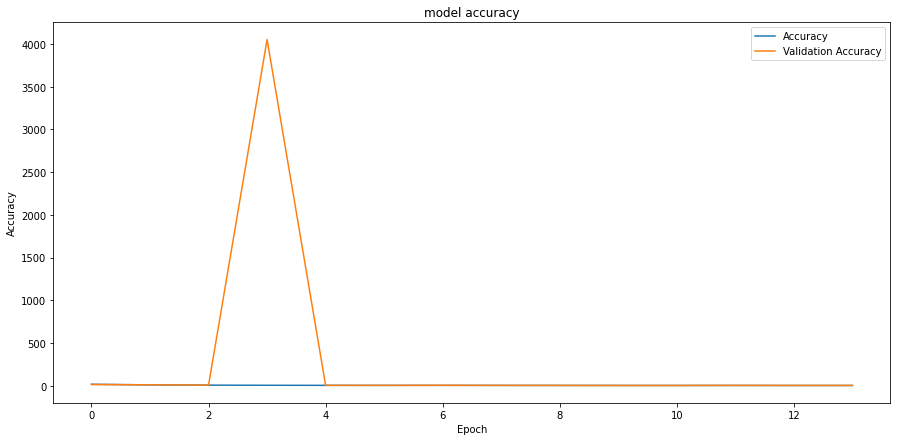

In [13]:
history_plot(history)